In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.speedup import calculate_speedups
sns.set_theme()

## Read data

In [2]:
threads = 32

branches = ['split-counters',
            'split-counters-no-jec',
            'split-counters-no-jec-sleepers-only',
            'split-counters-no-jec-sleepers-only-cache-padded']

our_df = None
master_df = None

for i in range(1, threads + 1):
    for branch in branches:
        filename = '11-07-2022/speedup-{}-{}-threads.csv'.format(branch, i)
        new_df = pd.read_csv(filename)
        new_df['threads'] = i
        new_df['branch'] = branch
        our_df = pd.concat([our_df, new_df], ignore_index = True)
        
    filename = '11-07-2022/speedup-master-{}-threads.csv'.format(i)
    new_master_df = pd.read_csv(filename)
    new_master_df['threads'] = i
    new_master_df['branch'] = 'master'
    master_df = pd.concat([master_df, new_master_df], ignore_index = True)

## Calculate speedups and prepare to plot

In [3]:
speedups_us = calculate_speedups(our_df)
speedups_us_df = pd.DataFrame(data=speedups_us)

speedups_master = calculate_speedups(master_df)
speedups_master_df = pd.DataFrame(data=speedups_master)

df = pd.concat([speedups_us_df, speedups_master_df], ignore_index = True)

## Plot fixed frequency speedups

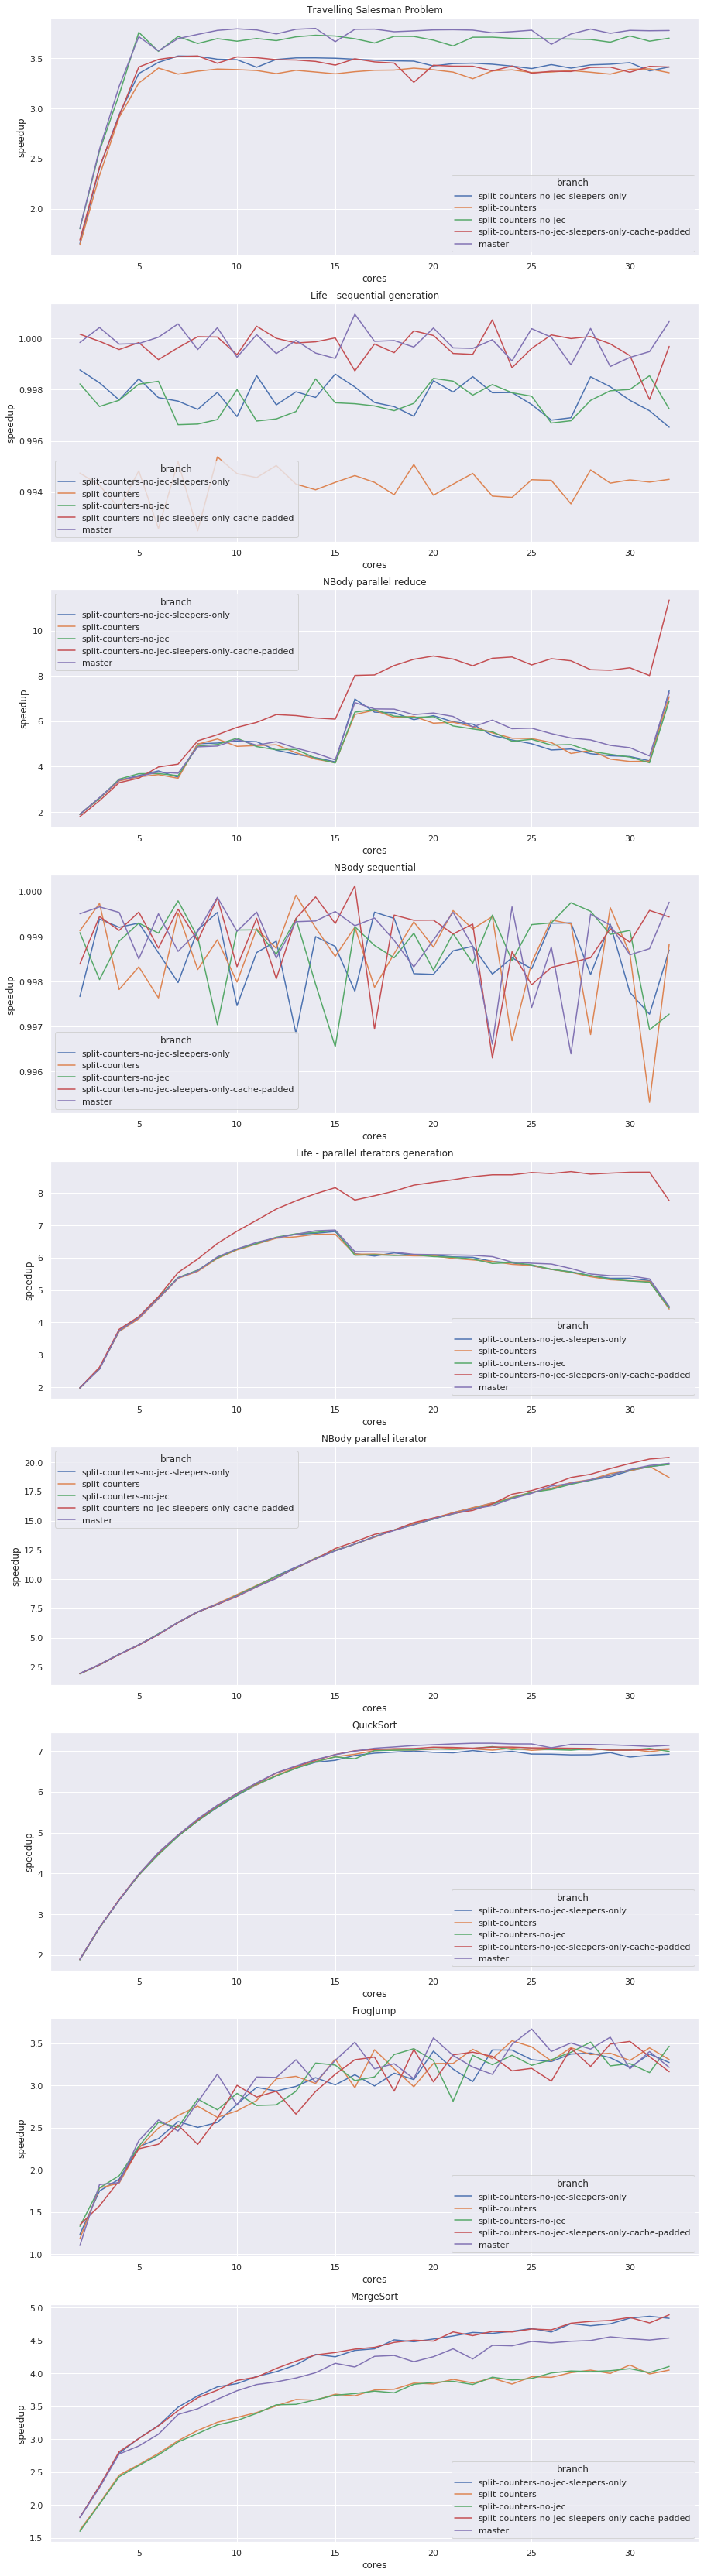

In [4]:
algorithms = set(df['name'])

fig, axs = plt.subplots(len(algorithms), figsize=(15, 60))

for i, algorithm in enumerate(algorithms):
    algorithm_df = df[df['name'] == algorithm]
    
    sns.lineplot(x='cores', y='speedup', hue='branch', data=algorithm_df, ax=axs[i]);
    axs[i].set_title(algorithm);    

## Branches

### master

Master branch of rayon without changes.

### split-counters

This branch uses one word for each atomic counter instead of packing all of them in a single word. There are three atomic counters: inactive threads, sleeping threads and the jobs event counter.

### split-counters-no-jec

Build on top of `split-counters`, this branch still uses three separeted counters, but remove the JEC mechanism.

### split-counters-no-jec-sleepers-only

Counters still split. When new jobs are posted, the default behavior of master is to use the number of inactive threads and the number of active threads to decide how many threads to wakeup. When the counters were packed, this could be done using only one load. After the counter were split, two loads were necessary in order to have the updated values of `sleeping_threads` and `inactive_threads`. Since the number of inactive threads was only used to an heuristic that doesn't look helpful, this branch removes the load and usage of `inactive_threads` and uses only the number of sleeping threads and the number of jobs to decide how many threads to wake up. 


## Conclusion

Spliting the counters didn't show significant improvements on performance. The `load` inside of the `new_jobs` function still appears to be a bottleneck. The load was not removed here because the number of sleeping threads needs to be loaded so that the scheduler can know how many threads it should wake up.

This is weird because on the branch `split-counters-no-jec-sleepers-only`, there shouldn't be a lot of writes on the `sleeping_threads` counter, so the loads should be almost cost-less (?). Maybe it's because the counters were not padded, which could cause them to be in the same cache line. Things to test: cache padding the counters and perf traces for cache misses.

Perf results per branch using 32 threads for LifeParIter are shown below:

### master 32 threads

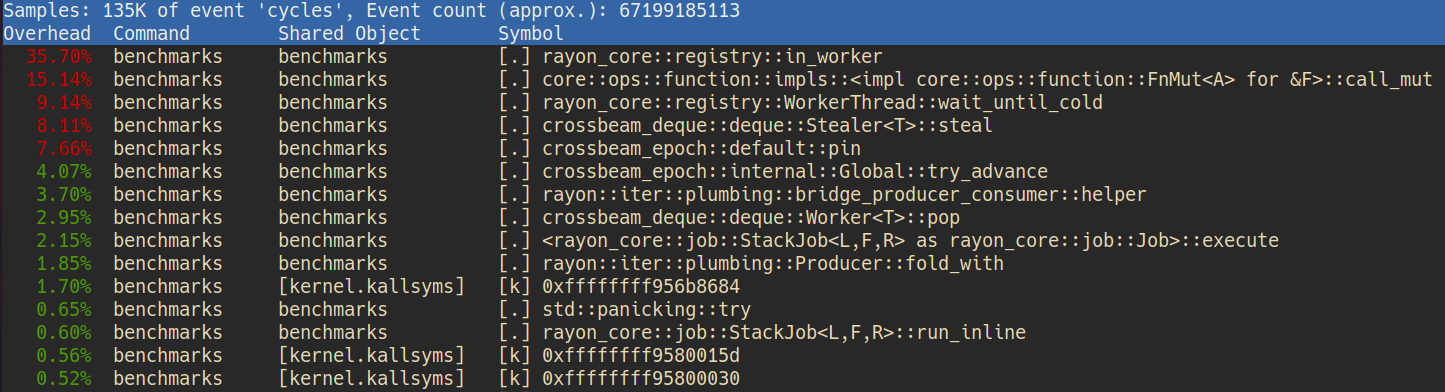

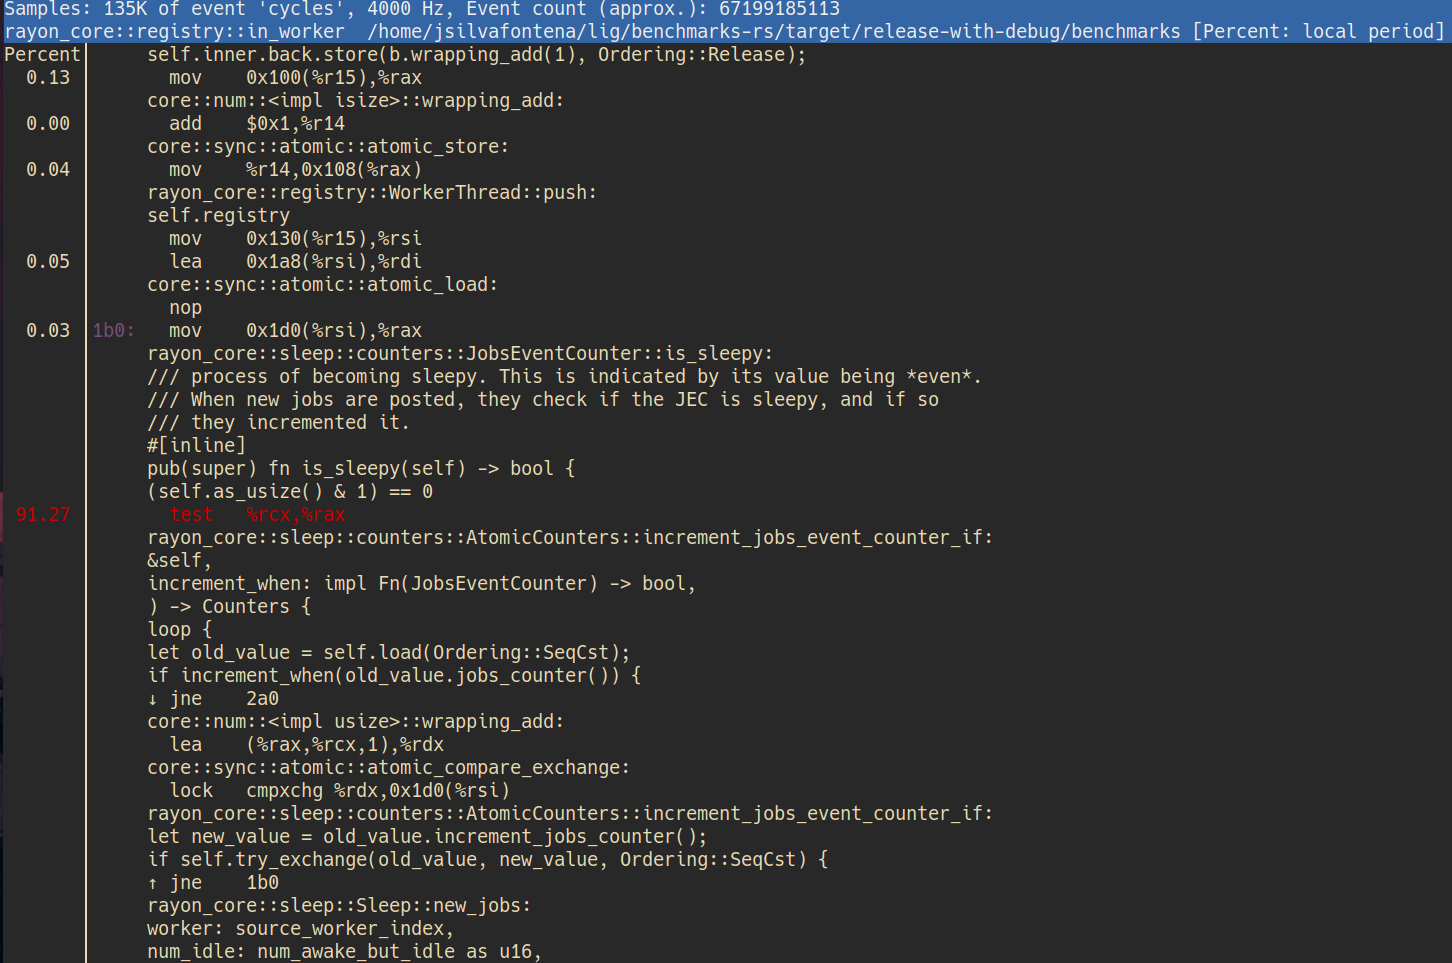

### split-counters 32 threads

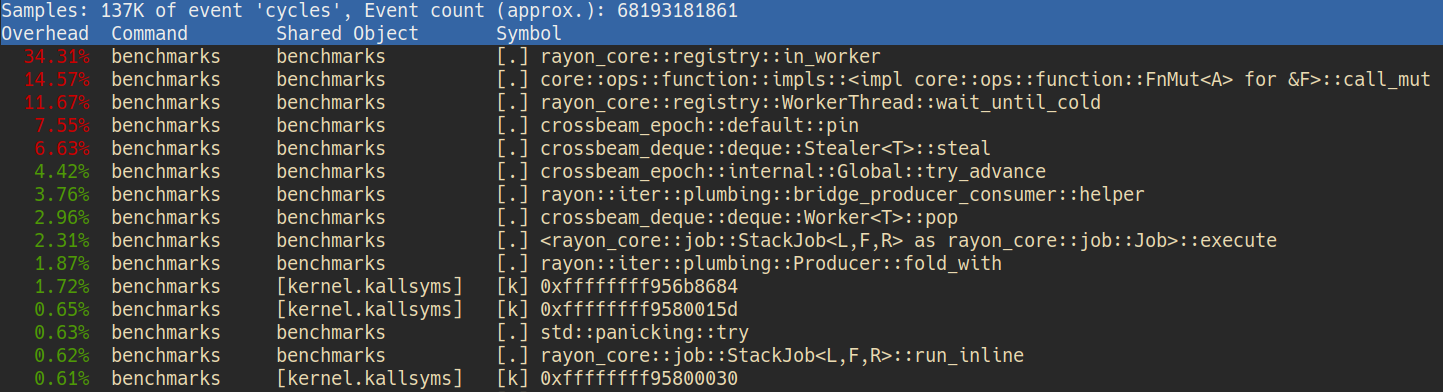

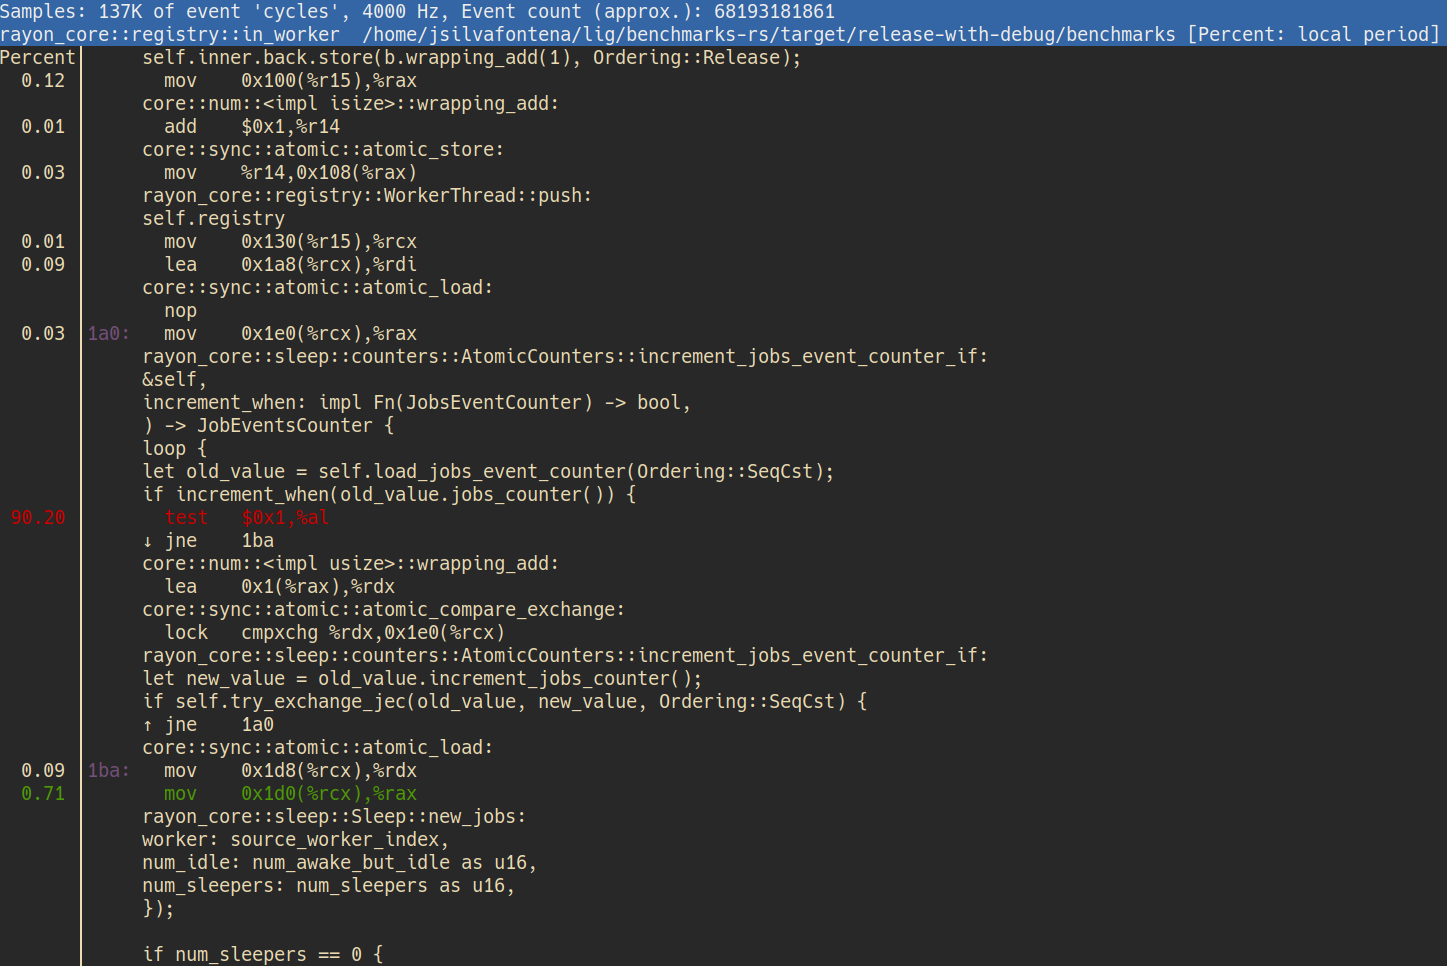

### split-counters-no-jec 32 threads

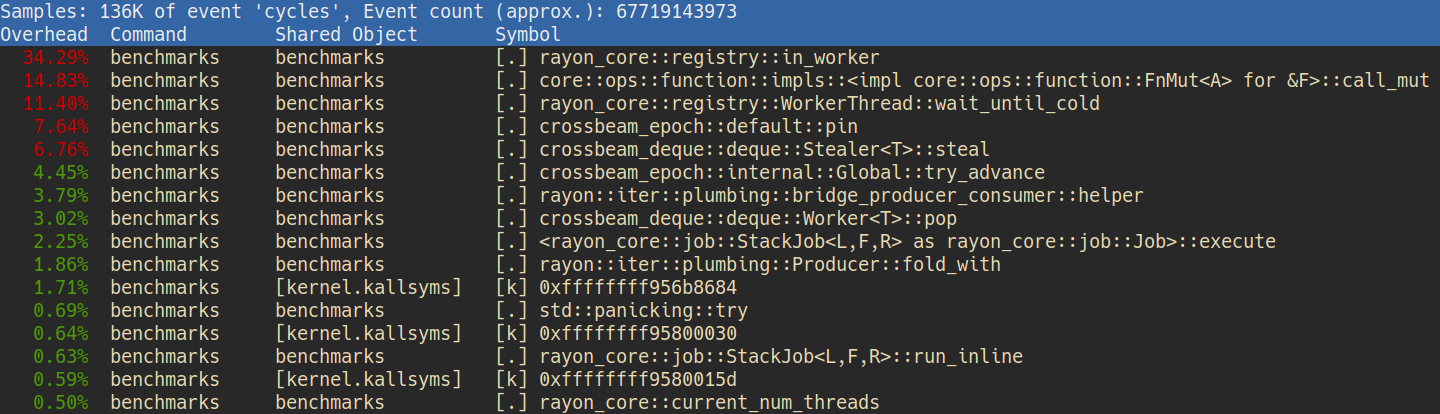

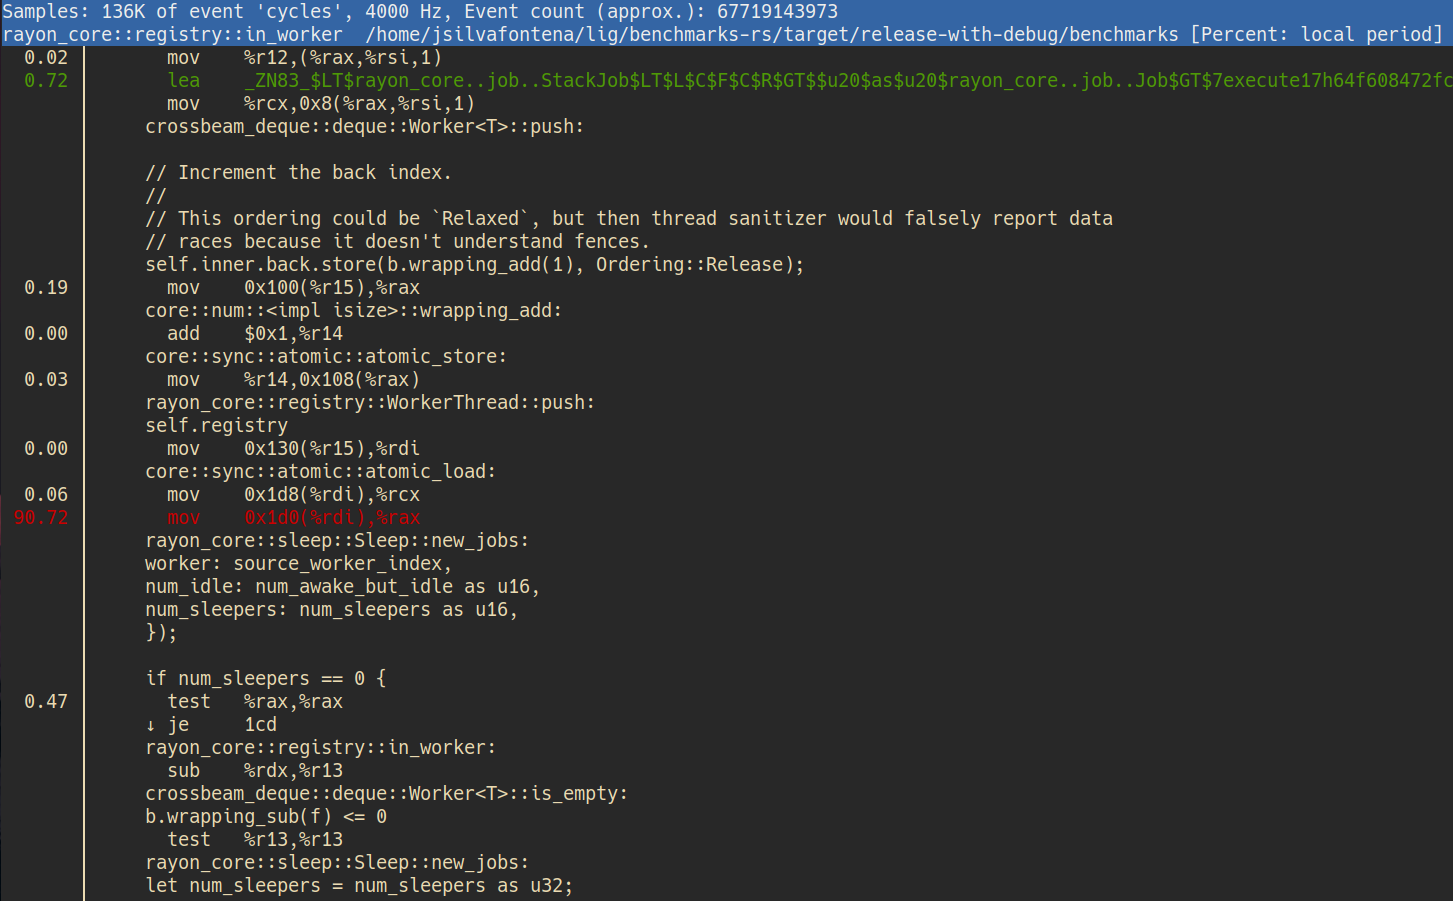

### split-counters-no-jec-sleepers-only

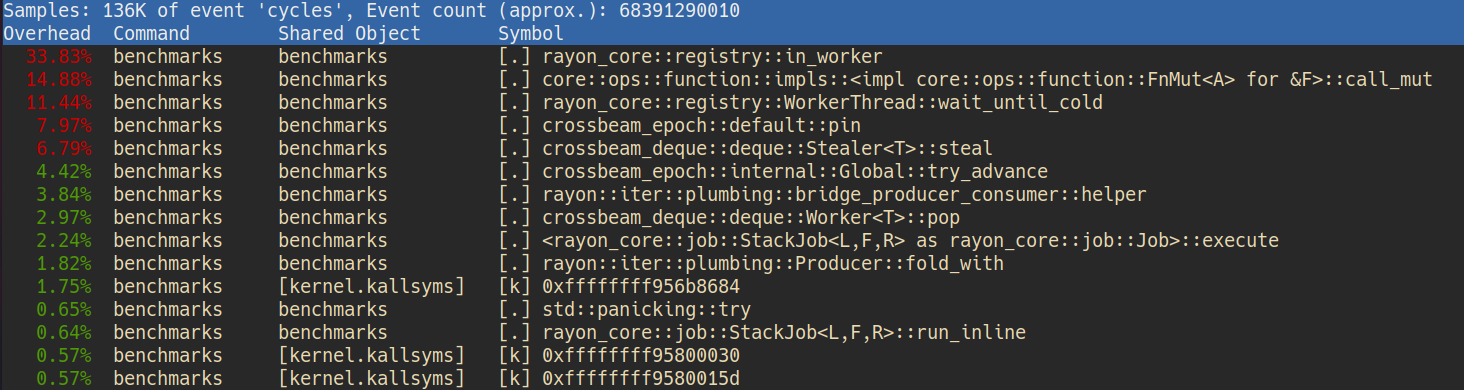

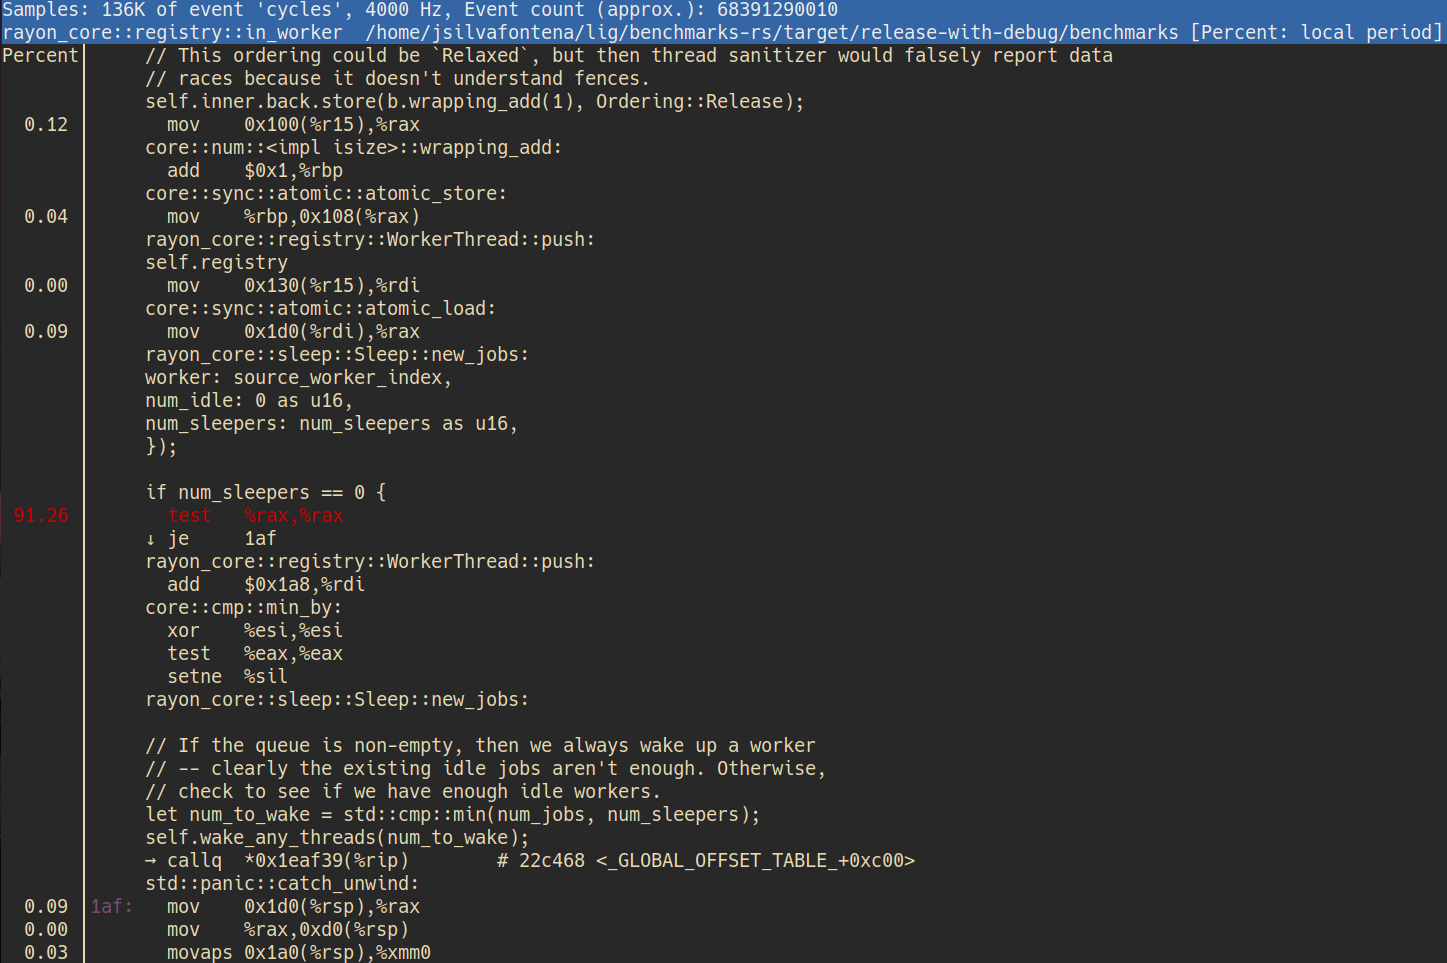